# Project Description

Sweet Lift Taxi has collected historical data on taxi requests at airports. To attract more drivers during peak hours, we need to predict the number of taxi requests for the next hour. Build a model for this prediction.

The RMSE metric on the test set should not exceed 48.

## Project Instructions

1. Download the data and resample for one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial data set. 4. Test the data using the test sample and provide a conclusion.

## Data Description

The data is stored in the file `taxi.csv`.

The number of requests is in the `num_orders` column.

## Preparation

In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
df= pd.read_csv('/Users/pauli/Documents/Data/sweet_lift_taxi/taxi.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


The datetime cell must be changed to the corresponding format.

In [4]:
#Change data type

df['datetime']= pd.to_datetime(df["datetime"])

print(df.dtypes)

datetime      datetime64[ns]
num_orders             int64
dtype: object


In [5]:
#Resampling data at 1-hour intervals.

df.set_index("datetime", inplace=True)
df= df.resample("H").mean()

/var/folders/cq/bs731p7n52x64481gqr1xjvm0000gn/T/ipykernel_34470/1131064308.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df= df.resample("H").mean()


In [6]:
#Sort the data chronologically

df.sort_index(inplace=True)
df = df.asfreq("H") 

/var/folders/cq/bs731p7n52x64481gqr1xjvm0000gn/T/ipykernel_34470/3023299180.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq("H")


In [7]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,20.666667
2018-03-01 01:00:00,14.166667
2018-03-01 02:00:00,11.833333
2018-03-01 03:00:00,11.000000
2018-03-01 04:00:00,7.166667


In [8]:
#Check for missing data

df.isna().sum()

num_orders    0
dtype: int64

## Analysis

In [9]:
df.describe()

,num_orders
count,4416.000000
mean,14.070463
std,7.503976
min,0.000000
25%,9.000000
50%,13.000000
75%,17.833333
max,77.000000


The average number of orders per hour is 84.42, although the standard deviation is 45.02, indicating considerable variability in orders per hour. Furthermore, there are hours with no orders (minimum 0), and the fact that the maximum is 462 suggests that there are outliers, but these outliers are considered part of the context or "natural," one might say. First, let's investigate whether the hours where the value is 0 are off-peak hours, such as early morning, or if it's an error in the data.

In [10]:
zero= df[df["num_orders"] == 0]

zero

,num_orders
datetime,
2018-04-06 06:00:00,0.0


There is only one hour with zero orders so it does not represent a significant data, and it was at 6 am.

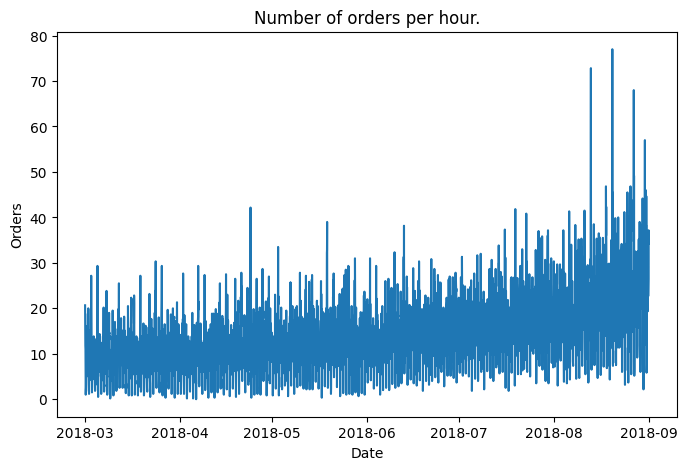

In [11]:
#Data visualization

plt.figure(figsize=(8, 5))
plt.plot(df.index, df['num_orders'])
plt.title('Number of orders per hour.')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.show()

A slight upward trend can be observed over the months. Now, let's break down the time series into trend, seasonality, and residual components.

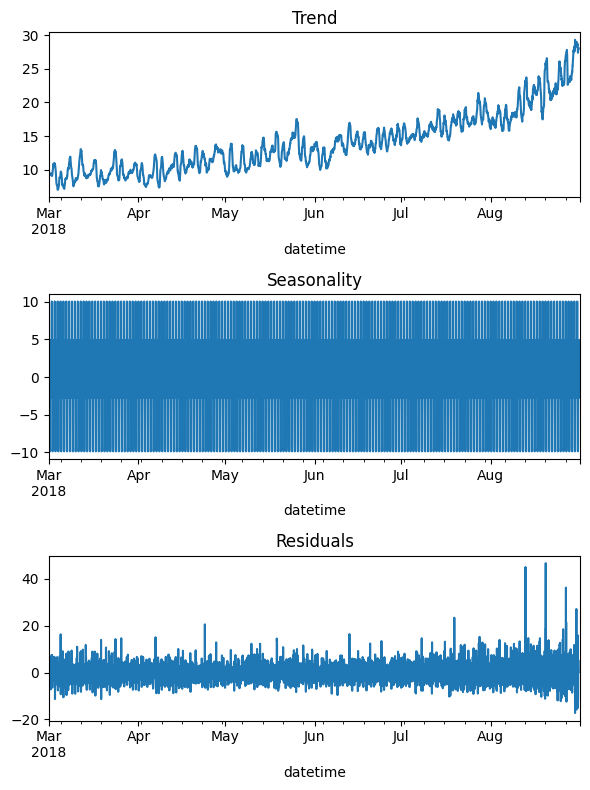

In [12]:
# Time series decomposition

decomposed =  seasonal_decompose(df["num_orders"], model="additive", period=24)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

The trend is clearly upward over the months, as we mentioned. Seasonality shows a constant daily volume and is overloaded, likely due to the periodicity. Peaks are observed in the residuals, indicating that there are events the model isn't explaining well (due to the aforementioned outliers), but most of the data is close to 0.

## Development

In [23]:
# Create lag features
def create_lag_features(df, target_col, lags=24):
    for lag in range(1, lags + 1):
        df[f"{target_col}_lag{lag}"] = df[target_col].shift(lag)
    return df

# Ensure that the data has an hourly frequency
df = df.asfreq("H")

# Create offset features
df = create_lag_features(df, "num_orders", lags=24)

#Remove NaN values ​​created by offsets
df.dropna(inplace=True)

/var/folders/cq/bs731p7n52x64481gqr1xjvm0000gn/T/ipykernel_34470/1475307963.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq("H")


In [24]:
# Divide data

train_size = int(len(df) * 0.9)
train, test = df.iloc[:train_size], df.iloc[train_size:]

X_train, y_train = train.drop(columns=["num_orders"]), train["num_orders"]
X_test, y_test = test.drop(columns=["num_orders"]), test["num_orders"]

In [25]:
# Train linear regression model (baseline test)
model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f'Coefficient of determination(R2): {r2}')

RMSE: 0.00
Coefficient of determination(R2): 1.0


The RMSE is quite low, but there's room for improvement with the R2. We'll test more models.

In [26]:
# Training Decision Tree Model

model = DecisionTreeRegressor(max_depth=10, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


rmse = root_mean_squared_error(y_test, y_pred)
r2 = model.score(X_test, y_test)

print(f"RMSE: {rmse:.2f}")
print(f"Coefficient of determination(R2): {r2:.3f}")

RMSE: 8.85
Coefficient of determination(R2): 0.185


An increased error compared to linear regression indicates that the model does not generalize well and is overfitting to the training data. A negative r2 means the model makes worse predictions than simply predicting the mean of the data. This model may be learning too much of the training details and not generalizing well. <br>
Let's try a random forest, which combines multiple trees and improves generalization.

In [29]:
# Train Random Forest model
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


rmse = root_mean_squared_error(y_test, y_pred)
r2 = model.score(X_test, y_test)

print(f"RMSE: {rmse:.2f}")
print(f"(R2): {r2:.3f}")

RMSE: 5.61
(R2): 0.673


The RMSE is better than in linear regression and decision trees, but there's still room for improvement, especially if we want to get closer to a higher r2. To improve performance, let's try Boosting, which is generally more accurate in time series.

In [30]:
model = LGBMRegressor(n_estimators=150, learning_rate=0.1, max_depth=7, random_state=42)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse')

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = model.score(X_test, y_test)

print(f"RMSE: {rmse:.2f}")
print(f"(R2): {r2:.3f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5911
[LightGBM] [Info] Number of data points in the train set: 3921, number of used features: 33
[LightGBM] [Info] Start training from score 13.108858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

The model's accuracy improved, with lower error and improved predictive capacity.
There is still room for improvement, as execution time was an issue in this case. CatBoost is efficient and fast on temporally ordered data.

In [31]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(n_estimators=200, learning_rate=0.1, depth=7, random_state=42, verbose=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = model.score(X_test, y_test)

print(f"RMSE: {rmse:.2f}")
print(f"(R2): {r2:.3f}")

RMSE: 5.09
(R2): 0.731


CatBoost has very similar performance, it may be a good choice for efficiency.

In [32]:
#Add new features to improve performance:

# Temporal characteristics
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)  # 1 si es sábado o domingo

# Rolling Mean
df['rolling_mean_3'] = df['num_orders'].rolling(window=3).mean()
df['rolling_mean_6'] = df['num_orders'].rolling(window=6).mean()
df['rolling_mean_12'] = df['num_orders'].rolling(window=12).mean()

# Lag Features 
df['lag_1'] = df['num_orders'].shift(1)
df['lag_2'] = df['num_orders'].shift(2)
df['lag_3'] = df['num_orders'].shift(3)

# Delete rows with NaN values ​​(produced by rolling and shift)
df.dropna(inplace=True)

In [33]:
#Training again with LightGBM, this model has been the best so far, so let's try it with the new data.

features = ['hour', 'dayofweek', 'is_weekend', 'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_12', 'lag_1', 'lag_2', 'lag_3']
X = df[features]
y = df['num_orders']

# Split into training set (90%) and test set (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=42)

# Train the model with the new data
model = LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, min_data_in_leaf=30, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


rmse = root_mean_squared_error(y_test, y_pred)
r2 = model.score(X_test, y_test)

print(f"New performance with Feature Engineering:")
print(f"RMSE: {rmse:.2f}")
print(f" (R2): {r2:.3f}")

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 3911, number of used features: 9
[LightGBM] [Info] Start training from score 13.122092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

There is a significant improvement over previous models in terms of RMSE, and the R2 is also much better than before (0.489), indicating that the model better explains the variability in the data. We are now below the threshold of RMSE < 48, which means we have met the project objective. <br>
Now that we have a good model, we can perform a more precise search to find the best combination of hyperparameters.

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 10]
}

model = LGBMRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = best_model.score(X_test, y_test)

print(f"Best configuration {grid_search.best_params_}")
print(f" Optimized RMSE: {rmse:.2f}")
print(f"Optimized R2: {r2:.3f}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 2607, number of used features: 9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1350
[LightGBM] [Info] Start training from score 14.709884
[LightGBM] [Info] Number of data points in the train set: 2607, number of used features: 9
[LightGBM] [Info] Start training from score 13.322529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

GridSearch didn't improve performance much, which suggests the model is already quite optimized with the current features so we'll use those since increasing the depth, decreasing the learning rate and increasing the n_estimators can slow down the model quite a bit and isn't worth it if there isn't a significant difference.

## Test

In [ ]:
# Separate the most recent 10% as the final test
test_size = int(len(df) * 0.1)
df_train = df.iloc[:-test_size]  
df_test_final = df.iloc[-test_size:] 


features = ['hour', 'dayofweek', 'is_weekend', 'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_12', 'lag_1', 'lag_2', 'lag_3']
X_train = df_train[features]
y_train = df_train['num_orders']
X_test_final = df_test_final[features]
y_test_final = df_test_final['num_orders']

# Retrain the model on the full training data
best_model.fit(X_train, y_train)


y_pred_final = best_model.predict(X_test_final)


rmse_final = root_mean_squared_error(y_test_final, y_pred_final)
r2_final = best_model.score(X_test_final, y_test_final)

print(f"Final test results:")
print(f"RMSE Final: {rmse_final:.2f}")
print(f"R2 Final: {r2_final:.3f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 3924, number of used features: 9
[LightGBM] [Info] Start training from score 13.107628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

## Conclusions

The objective of this project was to build a machine learning model to predict the number of taxi requests at airports in the next hour. This would allow the company to attract more drivers during peak hours and improve service efficiency.

To achieve this, we followed a structured approach that included data preprocessing, exploratory analysis, feature engineering, and predictive modeling.

The selected model (LightGBM) met the project objectives, as its RMSE was low and allowed for highly accurate predictions. Feature engineering was key to improving the model's performance, reducing the error from 7.51 to 5.32. The time-series-based approach was effective, with techniques such as lag features and moving averages capturing demand patterns well.